In [13]:
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D
from keras.layers import Dropout,Flatten,BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.models import load_model

In [14]:
(X_train,y_train),(X_test,y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [15]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.3,random_state=42)


In [16]:
print('Train Images Shape:',X_train.shape)
print('Train Labels Shape:',y_train.shape)

print('\nValidation Images Shape:',X_valid.shape)
print('Validation Labels Shape:',y_valid.shape)

print('\nTest Images Shape:',X_test.shape)
print('Test Labels Shape:',y_test.shape)


Train Images Shape: (35000, 32, 32, 3)
Train Labels Shape: (35000, 1)

Validation Images Shape: (15000, 32, 32, 3)
Validation Labels Shape: (15000, 1)

Test Images Shape: (10000, 32, 32, 3)
Test Labels Shape: (10000, 1)


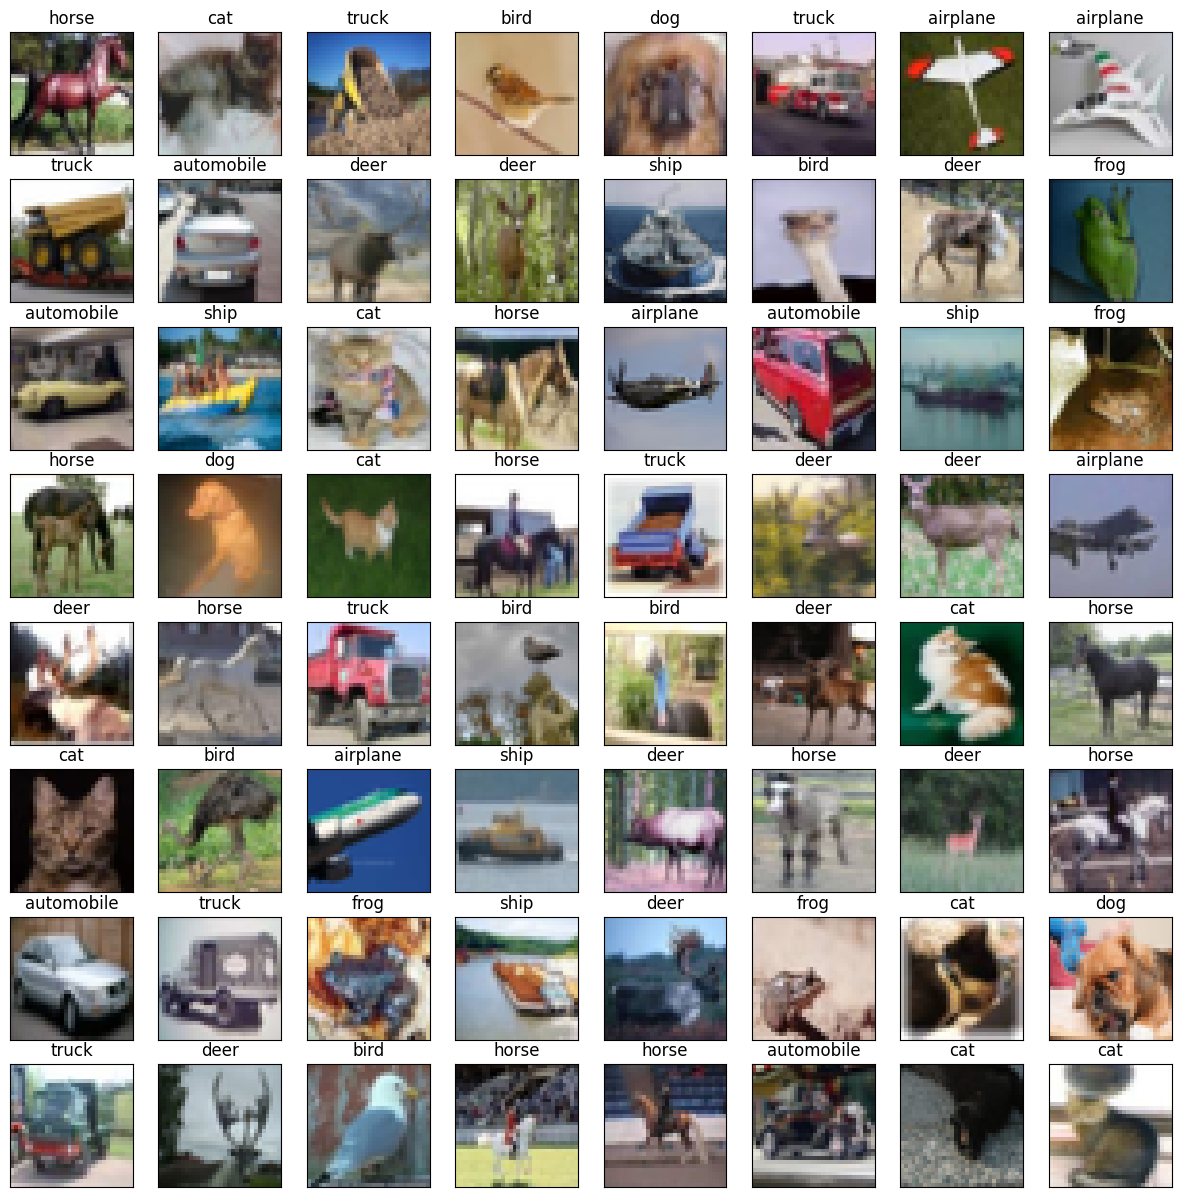

In [17]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(15,15))

for i in range(64):
  plt.subplot(8,8,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)

  plt.imshow(X_train[i])
  plt.title(class_names[y_train[i][0]],fontsize=12)

plt.show()

In [18]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_valid = X_valid.astype('float32')

mean = np.mean(X_train)
std = np.std(X_train)

X_train = (X_train-mean)/(std+1e-7)
X_test = (X_test-mean)/(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)


In [19]:
y_train = to_categorical(y_train,10)
y_valid = to_categorical(y_valid,10)
y_test = to_categorical(y_test,10)

In [20]:
data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.12,
    height_shift_range=0.12,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=[0.9,1.1],
    shear_range=10,
    channel_shift_range=0.1
)

In [21]:
model = Sequential()
weight_decay = 0.0001
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=l2(weight_decay),input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

model.add(Flatten())

model.add(Dense(10,activation='softmax'))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,176,970 (4.49 MB)

 Trainable params: 1,175,114 (4.48 MB)

 Non-trainable params: 1,856 (7.25 KB)

In [24]:
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer

batch_size = 64
epochs = 300
optimizer = Adam(learning_rate=0.0005)  # Use the imported Adam optimizer

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Add ReduceLROnPlateau callback
# Here, the learning rate will be reduced by half (factor=0.5) if no improvement in validation loss is observed for 10 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

# Fit the model on the training data, using the defined batch size and number of epochs
# The validation data is used to evaluate the model's performance during training
# The callbacks implemented are learning rate reduction when a plateau is reached in validation loss and
# stopping training early if no improvement is observed
model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
          epochs=epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[reduce_lr, early_stopping],
          verbose=2)

Epoch 1/10
547/547 - 55s - 100ms/step - accuracy: 0.8031 - loss: 0.7773 - val_accuracy: 0.8257 - val_loss: 0.7213 - learning_rate: 5.0000e-04
Epoch 2/10
547/547 - 36s - 65ms/step - accuracy: 0.8018 - loss: 0.7877 - val_accuracy: 0.8333 - val_loss: 0.7027 - learning_rate: 5.0000e-04
Epoch 3/10
547/547 - 36s - 66ms/step - accuracy: 0.8024 - loss: 0.7830 - val_accuracy: 0.8279 - val_loss: 0.7265 - learning_rate: 5.0000e-04
Epoch 4/10
547/547 - 37s - 68ms/step - accuracy: 0.8046 - loss: 0.7743 - val_accuracy: 0.8229 - val_loss: 0.7377 - learning_rate: 5.0000e-04
Epoch 5/10
547/547 - 37s - 67ms/step - accuracy: 0.8107 - loss: 0.7713 - val_accuracy: 0.8291 - val_loss: 0.7209 - learning_rate: 5.0000e-04
Epoch 6/10
547/547 - 37s - 67ms/step - accuracy: 0.8082 - loss: 0.7695 - val_accuracy: 0.8332 - val_loss: 0.7093 - learning_rate: 5.0000e-04
Epoch 7/10
547/547 - 37s - 68ms/step - accuracy: 0.8092 - loss: 0.7713 - val_accuracy: 0.8299 - val_loss: 0.7272 - learning_rate: 5.0000e-04
Epoch 8/10
5

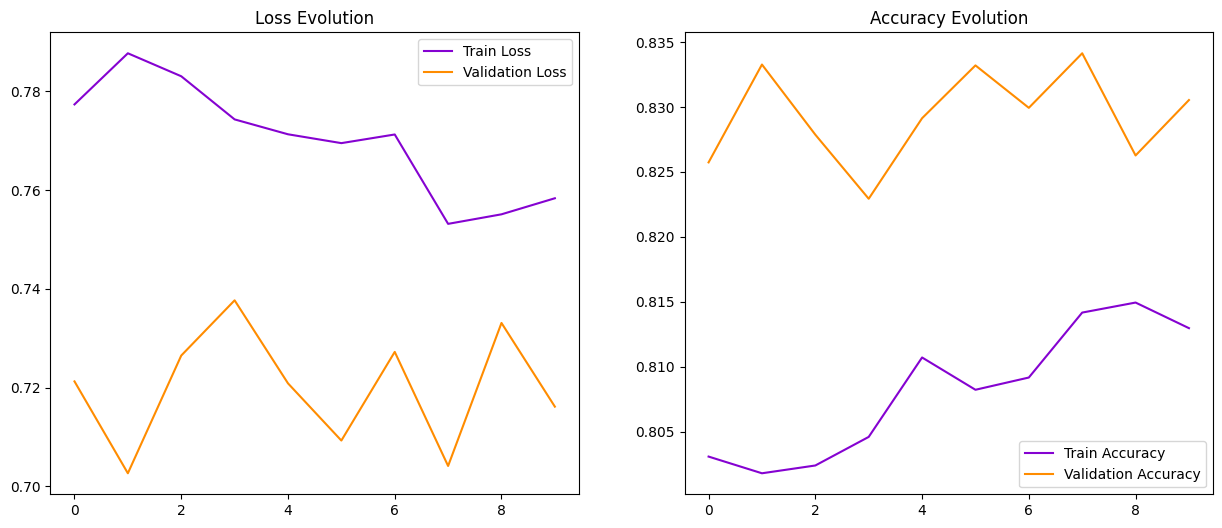

In [25]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')
plt.show()

In [26]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8348 - loss: 0.7074

Test Accuracy: 0.8335000276565552
Test Loss:     0.7155003547668457


In [27]:
url = "https://raw.githubusercontent.com/FarzadNekouee/Keras-CIFAR10-CNN-Model/master/truck_sample.png"
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)

# Convert the image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

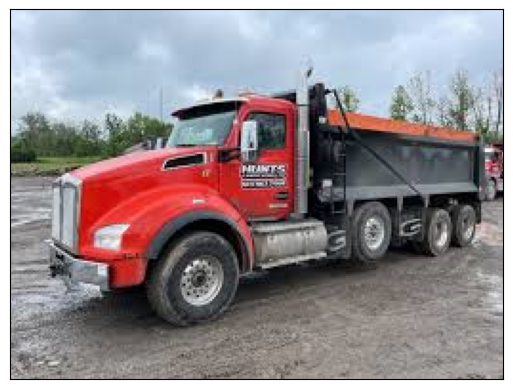

In [28]:
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

In [29]:
image = cv2.resize(image, (32,32))

# Normalize the image
image = (image-mean)/(std+1e-7)

# Add an extra dimension because the model expects a batch of images
image = image.reshape((1, 32, 32, 3))

In [30]:
prediction = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [31]:
predicted_class = prediction.argmax()

print('Predicted class: ', class_names[predicted_class])

Predicted class:  truck
